Generate Text Files for input

In [2]:
import os
import random
import string

# Function to generate random word
def generate_random_word(length):
    return ''.join(random.choice(string.ascii_lowercase) for _ in range(length))

# Function to generate a text file with specified size and random content
def generate_text_file(foldername,filename, size_in_bytes):
    filepath = os.path.join(foldername, filename)
    with open(filepath, 'w') as file:
        while os.path.getsize(filepath) < size_in_bytes:
            random_word = generate_random_word(random.randint(1, 10)) # Random word length between 1 to 10
            file.write(random_word + ' ')

# Generate 10 text files with varying sizes
foldername='InputFiles'
os.makedirs(foldername, exist_ok=True)
for i in range(10):
    size_in_kb = 32 * (2 ** i)  # Doubling size from 32kB to ~16MB
    size_in_bytes = size_in_kb * 1024
    filename = f"text_file_{size_in_kb}KB.txt"
    generate_text_file(foldername,filename, size_in_bytes)
    print(f"{filename} generated with size {size_in_kb}KB.")

text_file_32KB.txt generated with size 32KB.
text_file_64KB.txt generated with size 64KB.
text_file_128KB.txt generated with size 128KB.
text_file_256KB.txt generated with size 256KB.
text_file_512KB.txt generated with size 512KB.
text_file_1024KB.txt generated with size 1024KB.
text_file_2048KB.txt generated with size 2048KB.
text_file_4096KB.txt generated with size 4096KB.
text_file_8192KB.txt generated with size 8192KB.
text_file_16384KB.txt generated with size 16384KB.


Huffman Coding

In [27]:
import heapq
import os
import time

class HuffmanCoding:
    class Node:
        def __init__(self, char, freq):
            self.char = char
            self.freq = freq
            self.left = None
            self.right = None

        def __lt__(self, other):
            return self.freq < other.freq

    def __init__(self, filepath):
        self.filepath = filepath
        self.heap = []
        self.codes = {}
        self.reverse_mapping = {}

    def _calculate_frequency(self, text):
        frequency = {}
        for char in text:
            frequency[char] = frequency.get(char, 0) + 1
        return frequency

    def _build_heap(self, frequency):
        self.heap = [self.Node(char, freq) for char, freq in frequency.items()]
        heapq.heapify(self.heap)

    def _merge_nodes(self):
        while len(self.heap) > 1:
            node1 = heapq.heappop(self.heap)
            node2 = heapq.heappop(self.heap)
            merged = self.Node(None, node1.freq + node2.freq)
            merged.left = node1
            merged.right = node2
            heapq.heappush(self.heap, merged)

    def _generate_codes_helper(self, root, current_code):
        if root is None:
            return
        if root.char is not None:
            self.codes[root.char] = current_code
            self.reverse_mapping[current_code] = root.char
            return
        self._generate_codes_helper(root.left, current_code + "0")
        self._generate_codes_helper(root.right, current_code + "1")

    def _generate_codes(self):
        root = heapq.heappop(self.heap)
        self._generate_codes_helper(root, "")

    def _encode_text(self, text):
        return "".join(self.codes[char] for char in text)

    def _pad_encoded_text(self, encoded_text):
        extra_padding = 8 - len(encoded_text) % 8
        padded_encoded_text = encoded_text + "0" * extra_padding
        padded_info = "{0:08b}".format(extra_padding)
        return padded_info + padded_encoded_text

    def _write_to_file(self, padded_encoded_text, output_path):
        byte_array = bytearray(int(padded_encoded_text[i:i+8], 2) for i in range(0, len(padded_encoded_text), 8))
        with open(output_path, 'wb') as file:
            file.write(bytes(byte_array))

    def compress(self):
        filename, _ = os.path.splitext(self.filepath)
        output_path = filename + ".bin"

        with open(self.filepath, 'r') as file:
            text = file.read()
            frequency = self._calculate_frequency(text)
            self._build_heap(frequency)
            self._merge_nodes()
            self._generate_codes()
            encoded_text = self._encode_text(text)
            padded_encoded_text = self._pad_encoded_text(encoded_text)
            self._write_to_file(padded_encoded_text, output_path)

        print("Compressed")
        return output_path

    def _remove_padding(self, padded_encoded_text):
        padded_info = padded_encoded_text[:8]
        extra_padding = int(padded_info, 2)
        return padded_encoded_text[8 + extra_padding:]

    def _decode_text(self, encoded_text):
        current_code = ""
        decoded_text = ""
        for bit in encoded_text:
            current_code += bit
            if current_code in self.reverse_mapping:
                char = self.reverse_mapping[current_code]
                decoded_text += char
                current_code = ""
        return decoded_text

path = "InputFiles/text_file_16384KB.txt"

start = time.process_time()
h = HuffmanCoding(path)

output_path = h.compress()
print("Compressed file path:", output_path)



print("Original file size (KB):", os.path.getsize(path) / 1024)
print("Compressed file size (KB):", os.path.getsize(output_path) / 1024)

print(time.process_time() - start)

Compressed
Compressed file path: InputFiles/text_file_16384KB.bin
Original file size (KB): 16393.2919921875
Compressed file size (KB): 9481.806640625
5.6875


Lempelziv Coding

In [38]:
import os
from struct import *

def compress(input_file, n):
    maximum_table_size = 2 ** int(n)
    with open(input_file, 'r') as file:
        data = file.read()

    dictionary = {chr(i): i for i in range(256)}
    string = ""
    compressed_data = []

    for symbol in data:
        string_plus_symbol = string + symbol
        if string_plus_symbol in dictionary:
            string = string_plus_symbol
        else:
            compressed_data.append(dictionary[string])
            if len(dictionary) <= maximum_table_size:
                dictionary[string_plus_symbol] = len(dictionary)
            string = symbol

    if string in dictionary:
        compressed_data.append(dictionary[string])

    output_file = input_file.split(".")[0] + ".lzw"
    with open(output_file, "wb") as out_file:
        for data in compressed_data:
            out_file.write(pack('>H', data))

    print("Original file size (KB):", os.path.getsize(input_file) / 1024)
    print("Compressed file size (KB):", os.path.getsize(output_file) / 1024)


if __name__ == "__main__":
    input_file='InputFiles/text_file_16384KB.txt'
    n = 12

    start = time.process_time()
    # Compress
    compress(input_file, n)
    print(time.process_time() - start)



Original file size (KB): 16393.2919921875
Compressed file size (KB): 14522.3125
5.078125


Shannon Fano Coding

In [ ]:
import sys
import os


start = time.process_time()
if len(sys.argv) == 2:
    print ("No file input")
else:
    file_path = "InputFiles/text_file_1024KB.txt"
    with open(file_path, "rb") as file:
        file_data = bytearray(file.read())
        file_size = len(file_data)
        print ("Before encoding, the size of the file is", file_size/1024)

    byte_frequency = [0] * 256
    for byte in file_data:
        byte_frequency[byte] += 1

    byte_info_list = []
    for i in range(256):
        byte_info_list.append([i, byte_frequency[i], ''])

    sorted_byte_info = sorted(byte_info_list, key=lambda tup: tup[1], reverse=True)
    for i in range(len(sorted_byte_info)):
        if sorted_byte_info[i][1] == 0:
            zero_probability_index = i
            break

    def find_divide(byte_list):
        difference_list = []
        for k in range(len(byte_list)):
            sumA = sum(byte_list[i][1] for i in range(k))
            sumB = sum(byte_list[i][1] for i in range(k, len(byte_list)))
            difference = abs(sumA - sumB)
            difference_list.append((k, difference))
        sorted_difference_list = sorted(difference_list, key=lambda diff: diff[1])
        return sorted_difference_list[0][0]

    def shannon_fano_encoder(byte_list, direction):
        if len(byte_list) == 2:
            byte_list[0][2] += '0'
            byte_list[1][2] += '1'
            return True
        if len(byte_list) == 1:
            if direction == 'l':
                byte_list[0][2] += '0'
            elif direction == 'r':
                byte_list[0][2] == '1'
            else:
                print("Illegal parameter")
            return True
        divide_position = find_divide(byte_list)
        for i in range(divide_position):
            byte_list[i][2] += '0'
        for i in range(divide_position, len(byte_list)):
            byte_list[i][2] += '1'
        shannon_fano_encoder(byte_list[:divide_position], 'l')
        shannon_fano_encoder(byte_list[divide_position:], 'r')
        return byte_list

    encoded_byte_info = shannon_fano_encoder(sorted_byte_info[:zero_probability_index], 'l')
    encoding_dictionary = {}
    for i in range(len(encoded_byte_info)):
        encoding_dictionary[encoded_byte_info[i][0]] = encoded_byte_info[i][2]

    encoded_file = ""
    for byte in file_data:
        encoded_file += encoding_dictionary[byte]

    list_of_encoded_bytes = []
    for i in range(len(encoded_file) // 8):
        list_of_encoded_bytes.append(encoded_file[(i * 8):(i * 8 + 8)])
    last_substring_length = len(list_of_encoded_bytes[-1])

    if last_substring_length != 8:
        for i in range(8 - last_substring_length):
            list_of_encoded_bytes[-1] += '0'

    decimal_list = []
    for encoded_byte_str in list_of_encoded_bytes:
        encoded_byte_str = bytearray(encoded_byte_str, 'utf-8')
        decimal_value = 0
        for i in range(8):
            decimal_value += (encoded_byte_str[i] - 48) * 2 ** (7 - i)
        decimal_list.append(decimal_value)
    compressed_file = bytearray(decimal_list)

    print ("\nAfter compression, the size of the file is", len(compressed_file) / 1024)


print(time.process_time() - start)


In [55]:
#Code to generate the results table

import pandas as pd

result_file = pd.ExcelFile('AlgoResults.xlsx')
modified_sheets = {}
for sheet_name in result_file.sheet_names:
    df = pd.read_excel(result_file, sheet_name)
    df['Original_Size'] = df['Original_Size'].round(2)
    df['Compressed_Size'] = df['Compressed_Size'].round(2)
    df['Time_taken'] = df['Time_taken'].round(2)
    df['Compression_Factor'] = (df['Original_Size']/df['Compressed_Size']).round(4)
    df['Saving_Percentage'] = 1 - (df['Compressed_Size']/df['Original_Size']).round(4)
    modified_sheets[sheet_name] = df

with pd.ExcelWriter('AlgoResultsFinal.xlsx') as writer:
    for sheet_name, df in modified_sheets.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False)


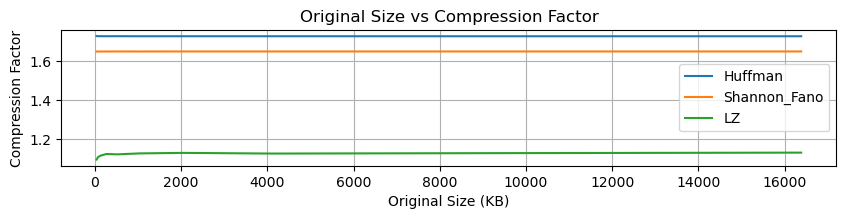

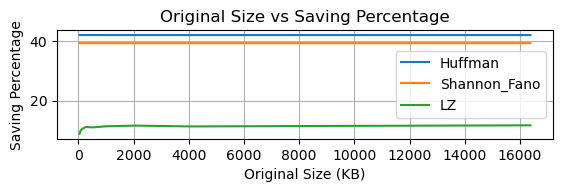

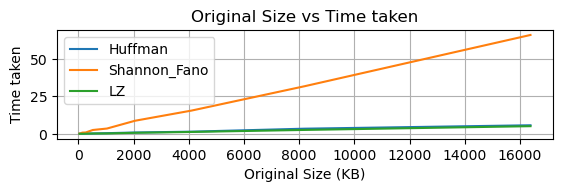

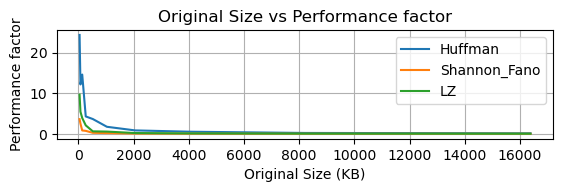

In [71]:
#Code to generate the results table

import pandas as pd
import matplotlib.pyplot as plt

excel_file = 'AlgoResultsFinal_2.xlsx'
xls = pd.ExcelFile(excel_file)

plt.figure(figsize=(10, 6))



for sheet_index, sheet_name in enumerate(xls.sheet_names):
    df = pd.read_excel(excel_file, sheet_name=sheet_name)
    
    # Plot Original Size vs Compression Factor
    plt.subplot(3, 1, 1)
    plt.plot(df['Original Size'], df['Compression Factor'], label=sheet_name)
    plt.xlabel('Original Size (KB)')
    plt.ylabel('Compression Factor')
    plt.title('Original Size vs Compression Factor')
    plt.grid(True)
    plt.legend()   
plt.show()


for sheet_index, sheet_name in enumerate(xls.sheet_names):
    df = pd.read_excel(excel_file, sheet_name=sheet_name)
    
     # Plot Original Size vs Saving Percentage
    plt.subplot(3, 1, 1)
    plt.plot(df['Original Size'], df['Saving Percentage'], label=sheet_name)
    plt.xlabel('Original Size (KB)')
    plt.ylabel('Saving Percentage')
    plt.title('Original Size vs Saving Percentage')
    plt.grid(True)
    plt.legend()

plt.show()

for sheet_index, sheet_name in enumerate(xls.sheet_names):
    df = pd.read_excel(excel_file, sheet_name=sheet_name)
    
     # Plot Original Size vs Time taken
    plt.subplot(3, 1, 1)
    plt.plot(df['Original Size'], df['Time taken'], label=sheet_name)
    plt.xlabel('Original Size (KB)')
    plt.ylabel('Time taken')
    plt.title('Original Size vs Time taken')
    plt.grid(True)
    plt.legend()  
    # Show the plot
plt.show()
    

for sheet_index, sheet_name in enumerate(xls.sheet_names):
    df = pd.read_excel(excel_file, sheet_name=sheet_name)
    
  # Plot Original Size vs Performance factor
    plt.subplot(3, 1, 1)
    plt.plot(df['Original Size'], df['Performance factor'], label=sheet_name)
    plt.xlabel('Original Size (KB)')
    plt.ylabel('Performance factor')
    plt.title('Original Size vs Performance factor')
    plt.grid(True)
    plt.legend()   
plt.show()